# Wildfires in the United States
Samantha Maillie and Ariel Sim

## Background

Every year wildfires cost billions, which is hardly comparable to the lives lost from wildfires, (3).
Utilizing an SQL database containing information on 1.88 million wildfires nationwide, we want
to investigate if cause of fire can be predicted by size and location of the fire. Why is this
important? Once fire blazes spread and grow to a certain point, keeping them under control
becomes very difficult and poses high risks. Our best bet, therefore, is to prevent wildfires from
starting at all if possible. As such, deeper understanding of the relationship between cause,
size, and location of fire can help fine tune policies designed to prevent wildfires, which in turn
offer better insight on wildfire prevention.

Our plan is to do some preliminary analysis to determine which classifications algorithms best
suit our problem. We will then implement the relevant procedures and compare them using
numerous methods including k-fold cross validation and confusion matrices.

Why this dataset? We wanted a dataset that could offer insight into a problem we are familiar
with. This dataset found at the link below is large, informative and not excessively worked over
like many of the datasets easily accessible online. This offers us the opportunity to discover new
conclusions from the dataset as opposed to essentially replicating results.

## Data Source and Description

This dataset was originally designed for the use of the Fire Protection Agency, (FPA). It contains
1.88 million data points with information on wildfires nationwide between the years 1992 and
2015, (8). The goal of this dataset’s publication on Kaggle is to investigate the relationship
between the size, location, and cause of wildfires, (8). Our project aims to tackle this problem.

The database in considerably large and can be downloaded via this link:
https://www.kaggle.com/rtatman/188-million-us-wildfires

## Supplementary Documents

The interested reader may wonder how we selected which variables to pull from the database and/or learn more about the models that were investigated. Documents titled "PotentialModels.pdf" and "WildfirePredictors.pdf" elaborating on both of these can be found in the GitHub repository for this project. 

## Code for Analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import numpy as np
import time
import sqlite3 as sql
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [2]:
start_time_notebook = time.time()

### This is for Cross Validation. These two lines only need to be listed once for all of the models.

In [3]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'

In [2]:
db = sql.connect("./FPA_FOD_20170508.sqlite")

In [3]:
cursor = db.cursor()

In [4]:
fire = pd.read_sql_query("SELECT STATE, FIRE_SIZE_CLASS, FIRE_SIZE, LATITUDE, LONGITUDE, STAT_CAUSE_CODE, STAT_CAUSE_DESCR FROM Fires", db)

In [5]:
fire.shape

(1880465, 7)

In [6]:
fire.dtypes

STATE                object
FIRE_SIZE_CLASS      object
FIRE_SIZE           float64
LATITUDE            float64
LONGITUDE           float64
STAT_CAUSE_CODE     float64
STAT_CAUSE_DESCR     object
dtype: object

## Preliminary Analysis

### Check for NA's

In [9]:
fire.isnull().sum()

STATE               0
FIRE_SIZE_CLASS     0
FIRE_SIZE           0
LATITUDE            0
LONGITUDE           0
STAT_CAUSE_CODE     0
STAT_CAUSE_DESCR    0
dtype: int64

In [10]:
# Saving the "cleaned" dataset to my computer so I don't want to keep running the code over again
fire.to_pickle("fire.pkl") 

### Examining Individual Potential Predictors

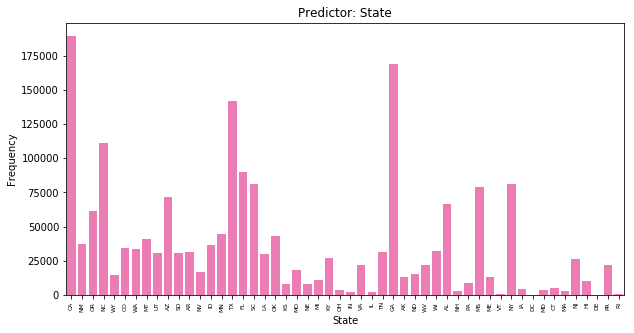

In [11]:
plt.rcParams['figure.figsize'] = [10, 5]
ax= sns.countplot(fire['STATE'], color = "hotpink")
plt.xticks(rotation=90, fontsize=6)
plt.title("Predictor: State",ha='center')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.show()

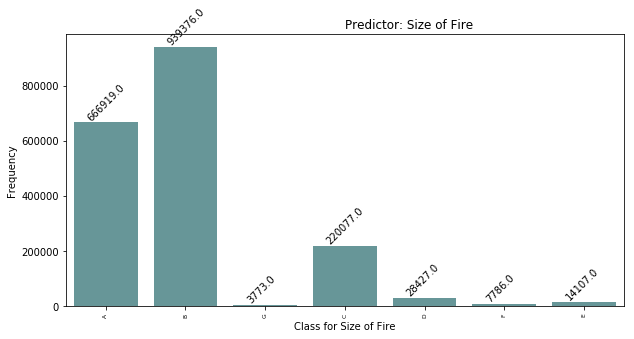

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
ax = sns.countplot(fire['FIRE_SIZE_CLASS'], color = "cadetblue")
plt.xticks(rotation=90, fontsize=6)
plt.title("Predictor: Size of Fire",ha='left')
plt.xlabel('Class for Size of Fire')
plt.ylabel('Frequency')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.15, p.get_height()+1), 
            ha='left', va='bottom', rotation = 45)
plt.show()

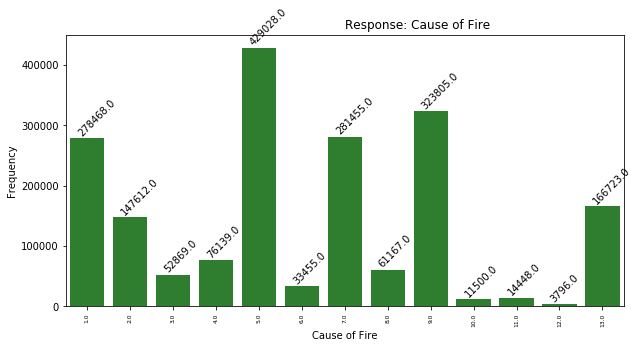

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]
ax = sns.countplot(fire['STAT_CAUSE_CODE'], color = "forestgreen")
plt.xticks(rotation=90, fontsize=6)
plt.title("Response: Cause of Fire",ha='left')
plt.xlabel('Cause of Fire')
plt.ylabel('Frequency')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.15, p.get_height()+1), 
            ha='left', va='bottom', rotation = 45)
plt.show()

### Code decription for STAT_CAUSE_CODE:

+ 1 - Lightning
+ 2 - Equipement Use
+ 3 - Smoking 
+ 4 - Campfire
+ 5 - Debris Burning
+ 6 - Railroad
+ 7 - Arson
+ 8 - Children
+ 9 - Miscellaneous
+ 10 - Fireworks
+ 11 - Powerline
+ 12 - Structure
+ 13 - Missing/Undefined

### Comparing distributions of cause code and description

Here we can see that cause code and descriptions match up, hence both are essentially duplicates of one another.

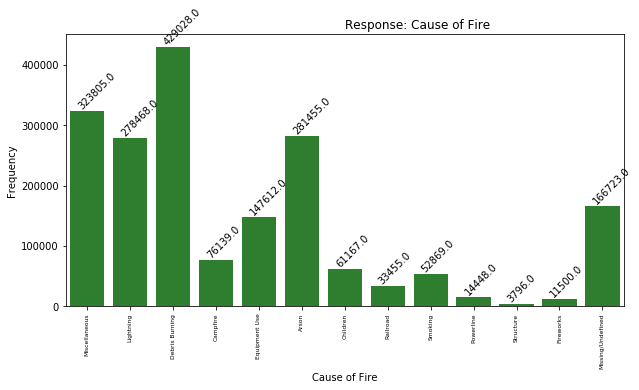

In [14]:
plt.rcParams['figure.figsize'] = [10, 5]
ax = sns.countplot(fire['STAT_CAUSE_DESCR'], color = "forestgreen")
plt.xticks(rotation=90, fontsize=6)
plt.title("Response: Cause of Fire",ha='left')
plt.xlabel('Cause of Fire')
plt.ylabel('Frequency')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.15, p.get_height()+1), 
            ha='left', va='bottom', rotation = 45)
plt.show()

### Transformation of Fire Size
We noticed that the dataset contained several fire sizes with high severity but low frequencies which skewed the data greatly to the right. If the initial split somehow captured more of these fire sizes than the test set did, our results would be skewed and bias as well. 

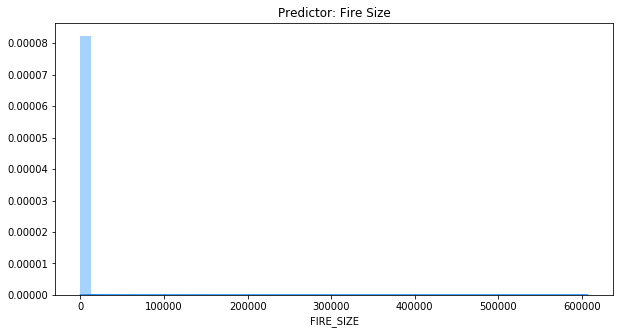

In [10]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.distplot(fire["FIRE_SIZE"], color = "dodgerblue")
plt.title("Predictor: Fire Size")
#plt.savefig('firesize.png')
plt.show()

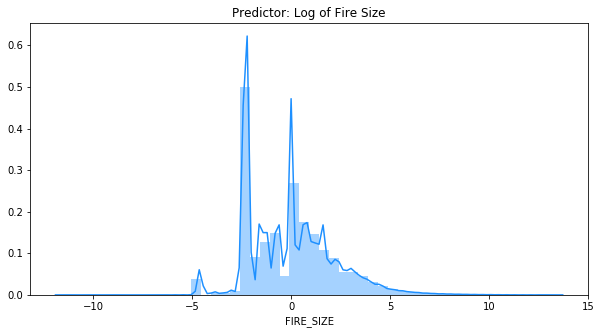

In [11]:
temp = fire["FIRE_SIZE"].apply(np.log)
sns.distplot(temp, color = "dodgerblue")
plt.title("Predictor: Log of Fire Size")
#plt.savefig('firesize.png')
plt.show()

In [9]:
print("Range of transformed fire size variable", (temp.min(), temp.max()))
print("Range of original fire size variable", (fire['FIRE_SIZE'].min(), fire['FIRE_SIZE'].max()))

Range of transformed fire size variable (-11.512925464970229, 13.316193456381152)
Range of original fire size variable (1.0000000000000001e-05, 606945.0)


The transformation adjusts the skewedness significantly and thus we will use the transformed variable in our model. 

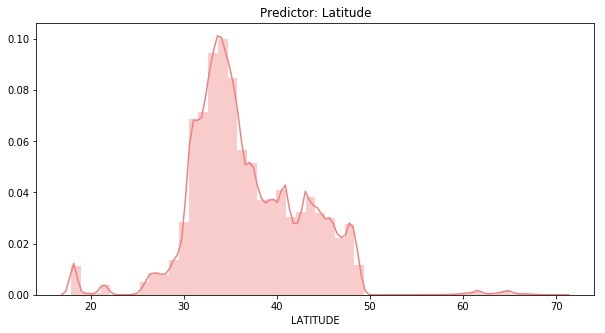

In [17]:
sns.distplot(fire["LATITUDE"], color = "lightcoral")
plt.title("Predictor: Latitude")
#plt.savefig('rr1.png')
plt.show()

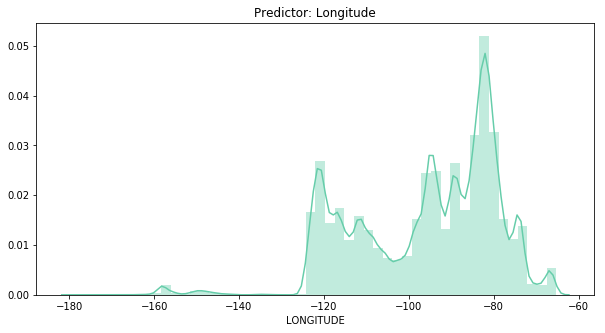

In [18]:
sns.distplot(fire["LONGITUDE"], color = "mediumaquamarine")
plt.title("Predictor: Longitude")
#plt.savefig('rr1.png')
plt.show()

In [19]:
X = fire[['LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'STATE']]

### Pairwise Plots
Latitude and Longitude look cool crossed together since they end up plotting the United States.

Pairwise plots code courtesey of The Art of Effective Visualization of Multi-Dimensional Data via towardsdatascience.com, (13)

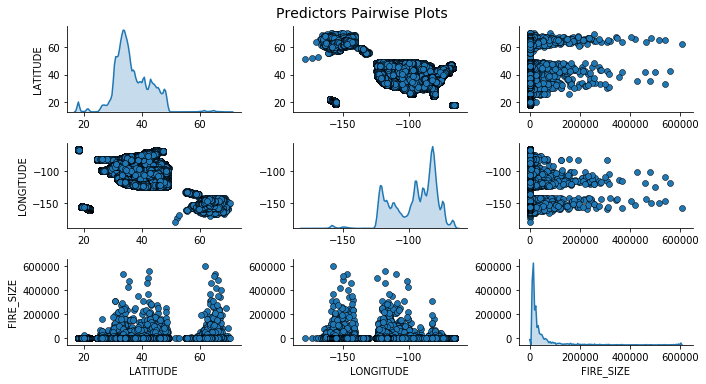

In [20]:
pp = sns.pairplot(X, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Predictors Pairwise Plots', fontsize=14)

## Model Selection and Validation

### Split into Train/Test

In [21]:
X = fire[['LATITUDE', 'LONGITUDE', 'FIRE_SIZE']]

In [22]:
# Checking for null values, drop if present
X.isnull().sum()

LATITUDE     0
LONGITUDE    0
FIRE_SIZE    0
dtype: int64

### Log transformation of fire-size

In [23]:
X.is_copy = False
X["FIRE_SIZE"] = fire["FIRE_SIZE"].apply(np.log)

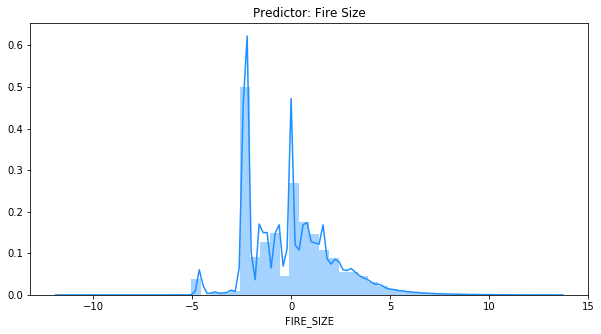

In [24]:
sns.distplot(X["FIRE_SIZE"], color = "dodgerblue")
plt.title("Predictor: Fire Size")
#plt.savefig('firesize.png')
plt.show()

In [25]:
y = fire['STAT_CAUSE_CODE']

# Split training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
X_tr.dtypes

LATITUDE     float64
LONGITUDE    float64
FIRE_SIZE    float64
dtype: object

# Tree Based Models 
These models all preformed relatively similarly. This makes sense since they are all based around the theory of decision trees. We use numerous techniques to evaluate the model's preformance. We use k-folds cross validation, confusion matrices and precision recall curves. Ensemble Extra trees does the best accross the board. Score is based upon the number of accurately predicted classes. These three methods all had similar scores but extra trees was the highest with about 44%. It also had the highest cross validation score, again 44%. 

Next we look at the confusion matrices. They all show these vertical heat lines at 0,4,6 and 8. It should be noted these are our largest classes. However, we can see a heat line strengthing across the diagonal for these three methods. In later models this will be absent. For the uninitiated, ideally you would want all the predicted points to lie on the diagonal because this would indicated that each point is predicted correctly. 

Lastly, we look at two types of PR Curves. We took advantage of functions provided by scklearn to accomdate multiclass classification PR curves, (5). The first one shows the average precision score for all classes. Random forests does a tiny bit better with a score of .4 compared to extra trees' .38. However, the low cross validation score random forests achieves encouraged us to keep extra trees as our model recommendation. We can also see the scores broken down by class which is quite interesting. 

We see that the trends are about the same across all three models, as would be expected in this case. Classes 0 and 12 dominate each time with high precision comapred to classes like 10 and 11 that consistantly falter. 0 and 12 make up lightning and missing. Where as 10 and 11 are powerline and structure. The interested reader can examine below each individual classes precision score. When considering a model we focused on the average precision score and the classification reports a little more than the individual class breakdowns. Particularly since they were so similar. 

In the end we find that the extra trees classifier is able to handle our data the best out of all the models we fit to this data.

## Ensemble Extra Trees Classifier - Our Pick

We did run these models with more trees (higher n_estimators) going up to 70-100 trees. However, the increase in predicative accuracy wasn't even a full percentage point and we decided the tiny increase in accuarcy was not worth the additional computing time since with that many trees it could sometimes take well over 30 minutes to run the section for one model. 

In [27]:
ETclf = ExtraTreesClassifier(n_estimators=10, max_depth=None, random_state=0)
ETclf.fit(X_tr, y_tr.values.ravel()) 
ETclf.score(X_te, y_te.values.ravel())

0.4442596204774556

In [28]:
results = model_selection.cross_val_score(ETclf, X_tr, y_tr.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Extra Trees average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Extra Trees average accuracy: 0.442


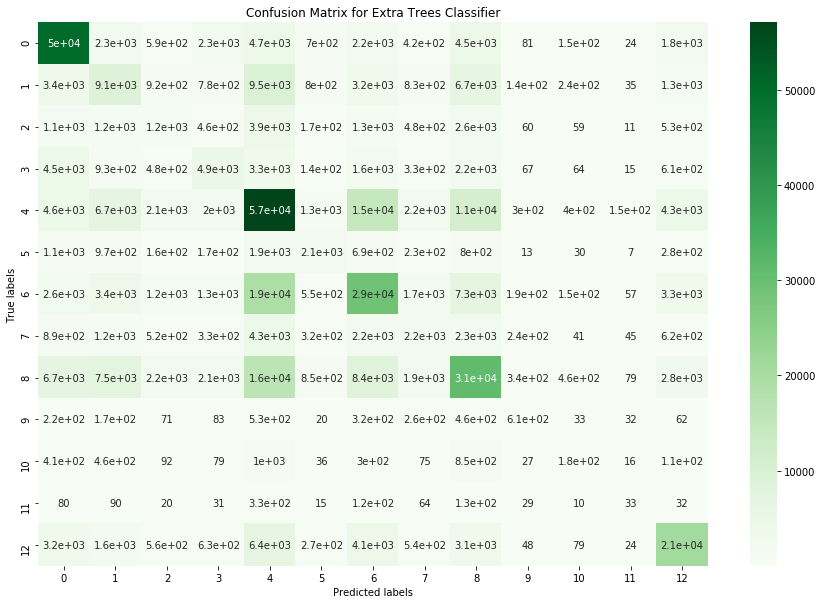

In [29]:
plt.rcParams['figure.figsize'] = [15, 10]
predET = ETclf.predict(X_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predET)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="Greens"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Extra Trees Classifier'); 

plt.show()

In [30]:
print(metrics.classification_report(y_te, predET))

             precision    recall  f1-score   support

        1.0       0.63      0.72      0.67     69992
        2.0       0.26      0.25      0.25     36910
        3.0       0.12      0.09      0.10     13081
        4.0       0.32      0.25      0.29     19130
        5.0       0.44      0.53      0.48    107147
        6.0       0.29      0.25      0.27      8479
        7.0       0.43      0.42      0.42     69991
        8.0       0.19      0.14      0.16     15251
        9.0       0.42      0.38      0.40     80898
       10.0       0.28      0.21      0.24      2877
       11.0       0.10      0.05      0.07      3645
       12.0       0.06      0.03      0.04       981
       13.0       0.57      0.51      0.54     41735

avg / total       0.43      0.44      0.44    470117



### Precison Recall Functions for Multiclass Classification - Ensemble Extra Trees

These functions are provided in the sklearn documentation for precision recall curves, (5). 

In [31]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=0)

# We use OneVsRestClassifier for multi-label prediction


# Run classifier
classifier = OneVsRestClassifier(ETclf)
classifier.fit(X_train, Y_train)
y_score = classifier.fit(X_train, Y_train).predict_proba(X_test)

Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.38')

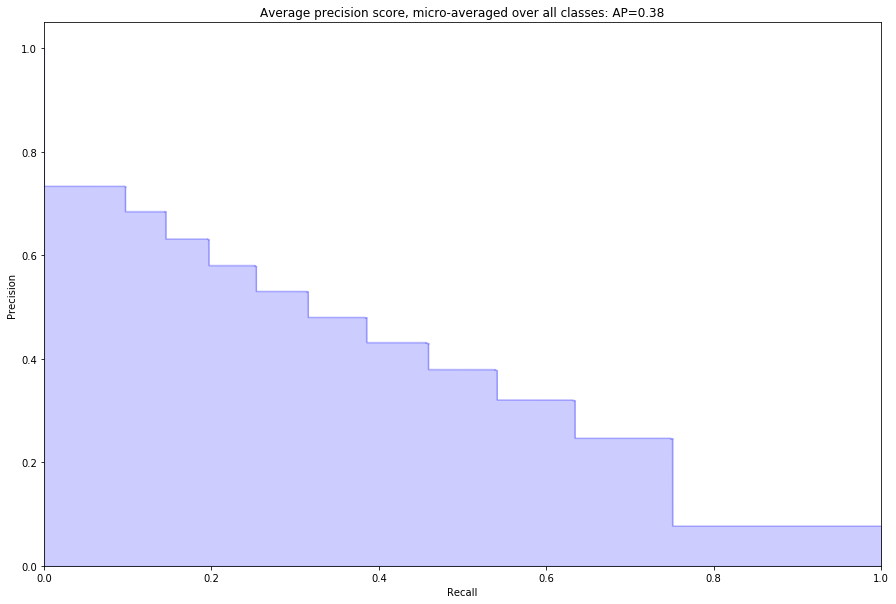

In [32]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

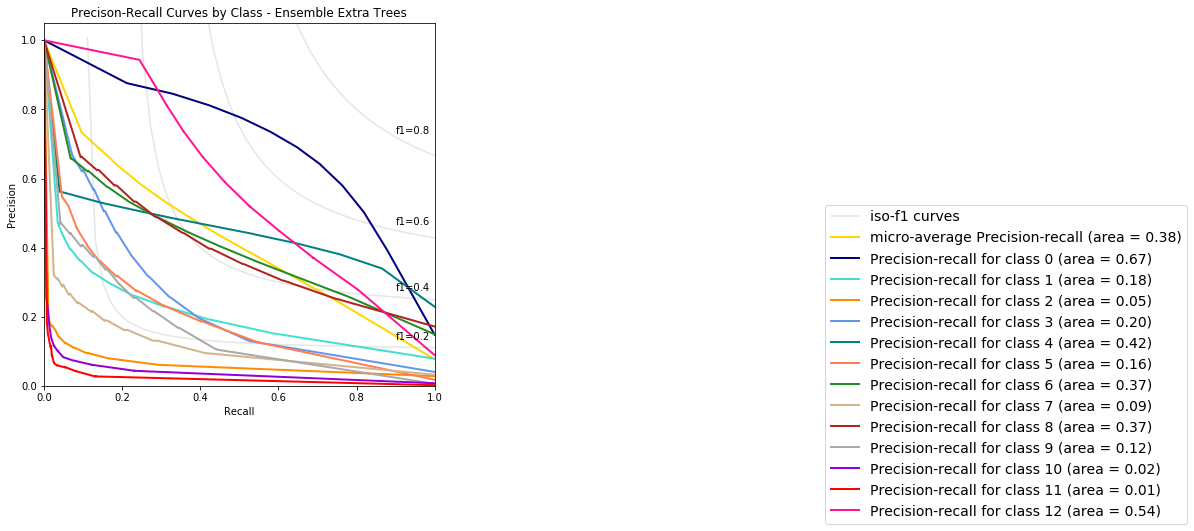

In [33]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'coral', 'forestgreen', 'tan', 'firebrick', 'darkgrey', 'darkviolet', 'red', 'deeppink'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precison-Recall Curves by Class - Ensemble Extra Trees')
plt.legend(lines, labels, loc=(2, -.38), prop=dict(size=14))


plt.show()

### Code decription for STAT_CAUSE_CODE:

Bulletted below are the labels representing the codes for cause of fire used in the Confusion Matrices below. Note the models assign values 0 to 12 even though the database lists the codes as 1 to 13. 

+ 0 - Lightning
+ 1 - Equipement Use
+ 2 - Smoking 
+ 3 - Campfire
+ 4 - Debris Burning
+ 5 - Railroad
+ 6 - Arson
+ 7 - Children
+ 8 - Miscellaneous
+ 9 - Fireworks
+ 10 - Powerline
+ 11 - Structure
+ 12 - Missing/Undefined

In [34]:
X = fire[['LATITUDE', 'LONGITUDE', 'FIRE_SIZE']]
y = fire['STAT_CAUSE_CODE']

## Random Forest 

In [35]:
RFclf = RandomForestClassifier(n_estimators=10,max_depth=None, random_state=0)
RFclf.fit(X_tr, y_tr.values.ravel()) 
RFclf.score(X_te, y_te.values.ravel())

0.44863938126040964

In [36]:
results = model_selection.cross_val_score(RFclf, X, y.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Random Forest average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Random Forest average accuracy: 0.354


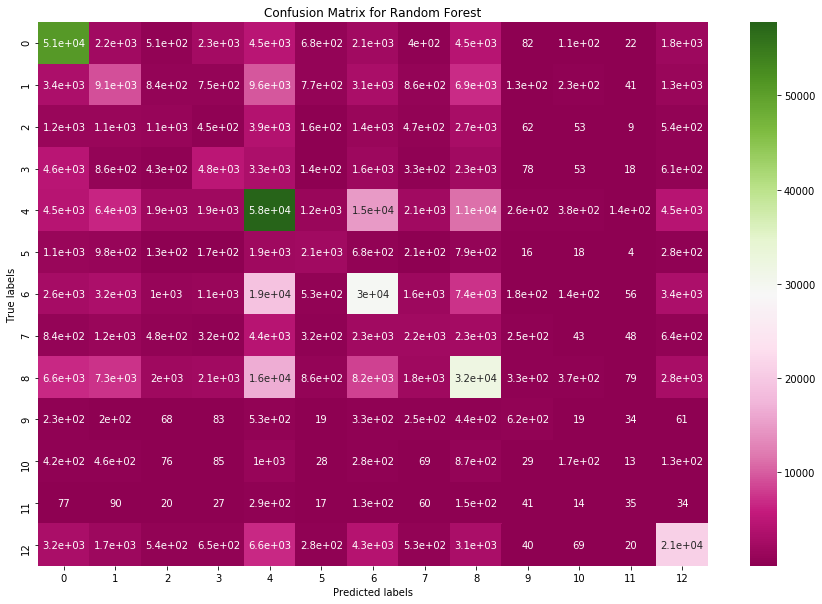

In [37]:
plt.rcParams['figure.figsize'] = [15, 10]
predRF = RFclf.predict(X_te)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predRF)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="PiYG"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Random Forest'); 
plt.show()

In [38]:
print(metrics.classification_report(y_te, predRF))

             precision    recall  f1-score   support

        1.0       0.64      0.73      0.68     69992
        2.0       0.26      0.25      0.25     36910
        3.0       0.12      0.08      0.10     13081
        4.0       0.33      0.25      0.29     19130
        5.0       0.45      0.54      0.49    107147
        6.0       0.30      0.25      0.27      8479
        7.0       0.43      0.42      0.43     69991
        8.0       0.20      0.14      0.17     15251
        9.0       0.43      0.39      0.41     80898
       10.0       0.29      0.22      0.25      2877
       11.0       0.10      0.05      0.06      3645
       12.0       0.07      0.04      0.05       981
       13.0       0.57      0.50      0.53     41735

avg / total       0.44      0.45      0.44    470117



### Precison Recall Functions for Multiclass Classification - Random Forest

These functions are provided in the sklearn documentation for precision recall curves, (5). 

In [39]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=0)

# We use OneVsRestClassifier for multi-label prediction
# Run classifier
classifier = OneVsRestClassifier(RFclf)
classifier.fit(X_train, Y_train)
y_score = classifier.fit(X_train, Y_train).predict_proba(X_test)

Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.40')

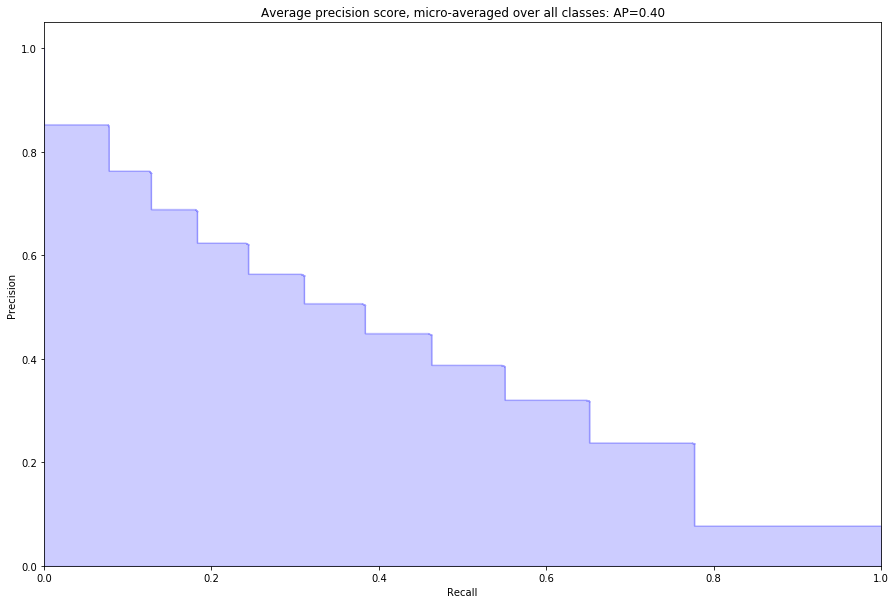

In [40]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")

plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

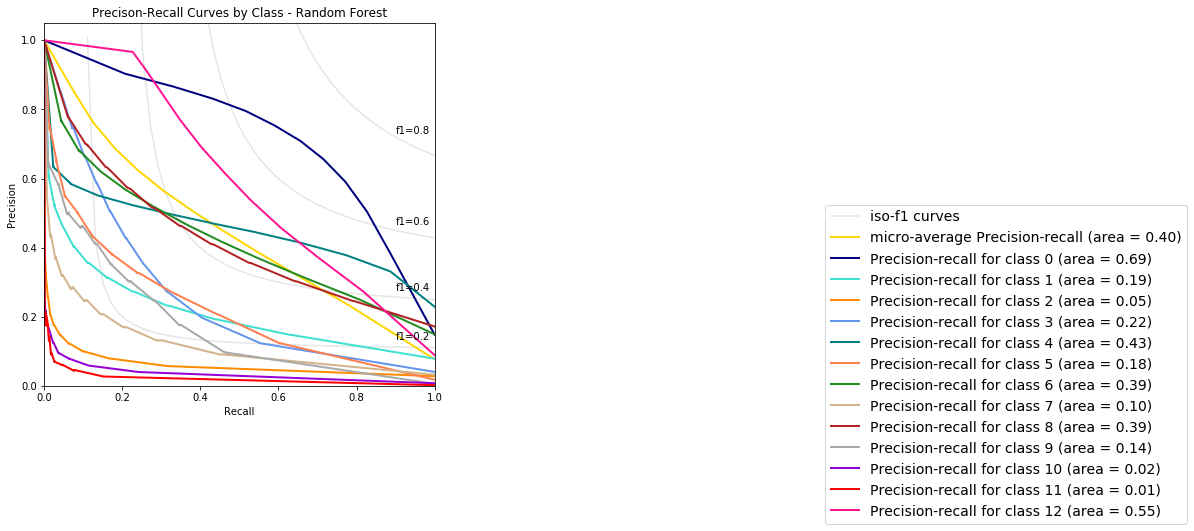

In [41]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'coral', 'forestgreen', 'tan', 'firebrick', 'darkgrey', 'darkviolet', 'red', 'deeppink'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precison-Recall Curves by Class - Random Forest')
plt.legend(lines, labels, loc=(2, -.38), prop=dict(size=14))


plt.show()

### Code decription for STAT_CAUSE_CODE:

Bulletted below are the labels representing the codes for cause of fire used in the Confusion Matrices below. Note the models assign values 0 to 12 even though the database lists the codes as 1 to 13. 

+ 0 - Lightning
+ 1 - Equipement Use
+ 2 - Smoking 
+ 3 - Campfire
+ 4 - Debris Burning
+ 5 - Railroad
+ 6 - Arson
+ 7 - Children
+ 8 - Miscellaneous
+ 9 - Fireworks
+ 10 - Powerline
+ 11 - Structure
+ 12 - Missing/Undefined

In [42]:
X = fire[['LATITUDE', 'LONGITUDE', 'FIRE_SIZE']]
y = fire['STAT_CAUSE_CODE']

## Decision Tree

In [43]:
DTclf = DecisionTreeClassifier(min_samples_leaf = 4,random_state=0)
DTclf.fit(X_tr, y_tr.values.ravel()) 
DTclf.score(X_te, y_te.values.ravel())

0.43645730743623395

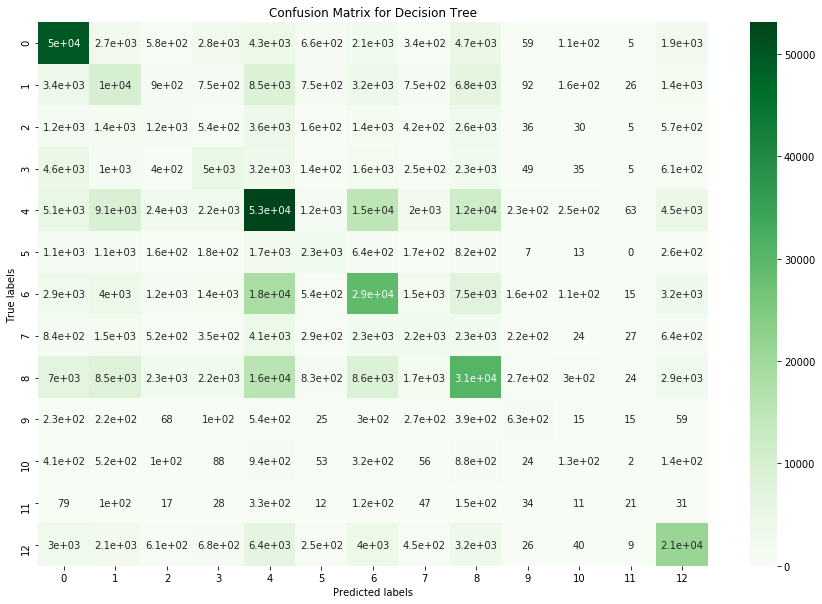

In [44]:
plt.rcParams['figure.figsize'] = [15, 10]
predDT = DTclf.predict(X_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predDT)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="Greens"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Decision Tree'); 

plt.show()

In [45]:
print(metrics.classification_report(y_te, predDT))

             precision    recall  f1-score   support

        1.0       0.62      0.71      0.66     69992
        2.0       0.24      0.27      0.26     36910
        3.0       0.11      0.09      0.10     13081
        4.0       0.31      0.26      0.28     19130
        5.0       0.44      0.50      0.47    107147
        6.0       0.32      0.27      0.29      8479
        7.0       0.42      0.42      0.42     69991
        8.0       0.22      0.14      0.17     15251
        9.0       0.41      0.38      0.40     80898
       10.0       0.34      0.22      0.27      2877
       11.0       0.11      0.04      0.05      3645
       12.0       0.10      0.02      0.04       981
       13.0       0.56      0.50      0.53     41735

avg / total       0.43      0.44      0.43    470117



In [46]:
results = model_selection.cross_val_score(DTclf, X_tr, y_tr.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Decision Tree average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Decision Tree average accuracy: 0.434


### Precison Recall Functions for Multiclass Classification - Decision Tree

These functions are provided in the sklearn documentation for precision recall curves, (5). 

In [47]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=0)

# We use OneVsRestClassifier for multi-label prediction
# Run classifier
classifier = OneVsRestClassifier(DTclf)
classifier.fit(X_train, Y_train)
y_score = classifier.fit(X_train, Y_train).predict_proba(X_test)

Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.34')

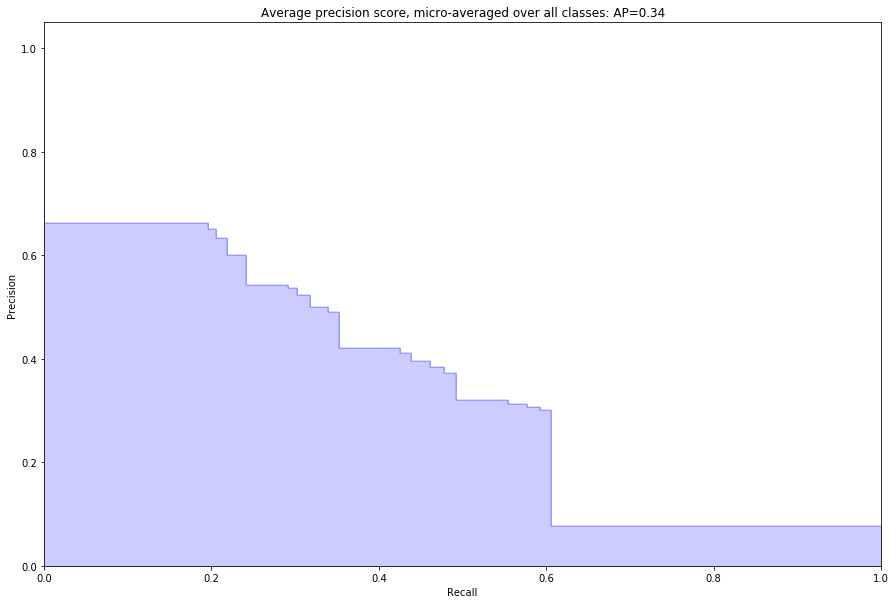

In [48]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")

plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

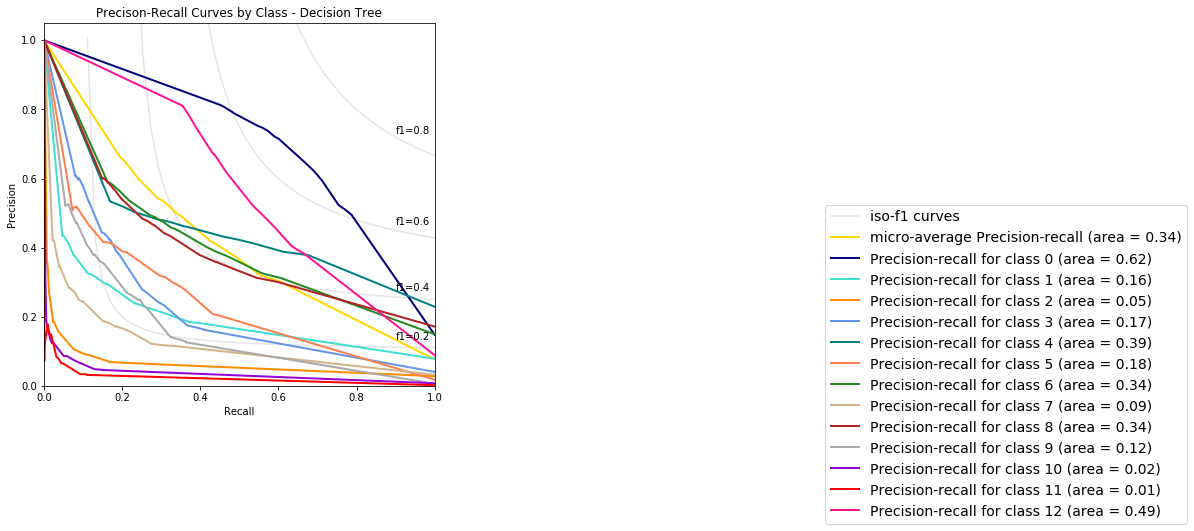

In [49]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'coral', 'forestgreen', 'tan', 'firebrick', 'darkgrey', 'darkviolet', 'red', 'deeppink'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precison-Recall Curves by Class - Decision Tree')
plt.legend(lines, labels, loc=(2, -.38), prop=dict(size=14))


plt.show()

### Code decription for STAT_CAUSE_CODE:

Bulletted below are the labels representing the codes for cause of fire used in the Confusion Matrices below. Note the models assign values 0 to 12 even though the database lists the codes as 1 to 13. 

+ 0 - Lightning
+ 1 - Equipement Use
+ 2 - Smoking 
+ 3 - Campfire
+ 4 - Debris Burning
+ 5 - Railroad
+ 6 - Arson
+ 7 - Children
+ 8 - Miscellaneous
+ 9 - Fireworks
+ 10 - Powerline
+ 11 - Structure
+ 12 - Missing/Undefined

In [50]:
X = fire[['LATITUDE', 'LONGITUDE', 'FIRE_SIZE']]
y = fire['STAT_CAUSE_CODE']

## Less Successful Models
Each of the following models we considered but they showed similar inabilities to accurately predict. Instead of having a strong line done the center of the confusion matrix some of these plots are producing vertical trends, particaularly focused on classes 0, 4, 6 and 8. It is worth noting these are the four largest classes. Each of these models ended up having whole classes they never even assigned predicitions to as can be seen in the confusin matrices provided. It tells us something about our dataset. We have an uneven distribution of classes and we are seeing that some of these models are prediciting which class has the most points in it which indicates that there is some missing information in regards to what is starting the fires. These models are not able to handle this as well as the decision tree based models. 

In [51]:
from sklearn import preprocessing
X_stand_tr = preprocessing.scale(X_tr)
X_stand_te = preprocessing.scale(X_te)
Rclf = RidgeClassifierCV()
Rclf.fit(X_stand_tr, y_tr.values.ravel()) 
Rclf.score(X_stand_te, y_te.values.ravel())

0.31454722973217303

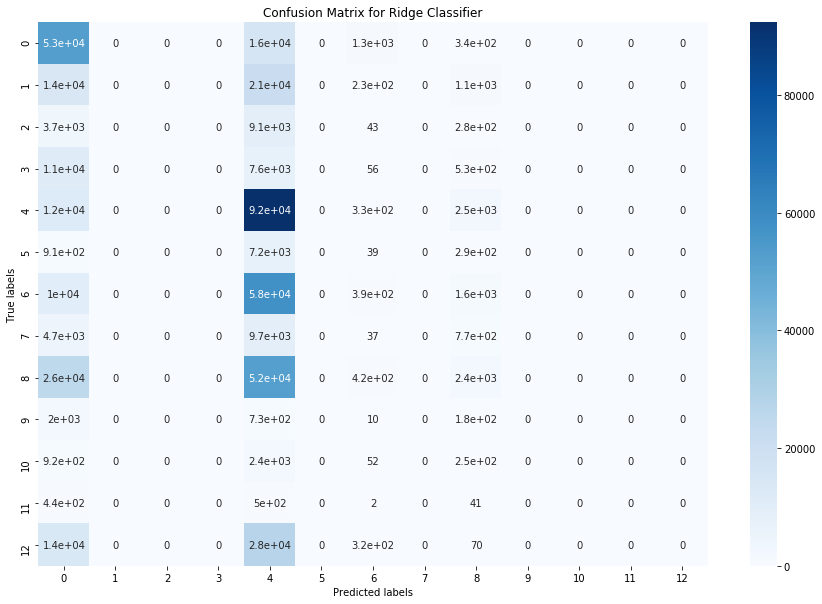

In [52]:
plt.rcParams['figure.figsize'] = [15, 10]
predR = Rclf.predict(X_stand_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predR)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Ridge Classifier'); 

plt.show()

In [53]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(Rclf, X_stand_tr, y_tr.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Ridge Classifer average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Ridge Classifer average accuracy: 0.314


In [54]:
print(metrics.classification_report(y_te, predR))

             precision    recall  f1-score   support

        1.0       0.35      0.75      0.47     69992
        2.0       0.00      0.00      0.00     36910
        3.0       0.00      0.00      0.00     13081
        4.0       0.00      0.00      0.00     19130
        5.0       0.30      0.86      0.45    107147
        6.0       0.00      0.00      0.00      8479
        7.0       0.12      0.01      0.01     69991
        8.0       0.00      0.00      0.00     15251
        9.0       0.23      0.03      0.05     80898
       10.0       0.00      0.00      0.00      2877
       11.0       0.00      0.00      0.00      3645
       12.0       0.00      0.00      0.00       981
       13.0       0.00      0.00      0.00     41735

avg / total       0.18      0.31      0.18    470117



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic Regression- Implemented this way will fit the model using one versus the rest methods (see suplementary text on potential models for further explanation)


In [55]:
logRegr = LogisticRegression()

In [56]:
logRegr.fit(X_tr, y_tr.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
logRegr.score(X_te, y_te.values.ravel())

0.31402820999878756

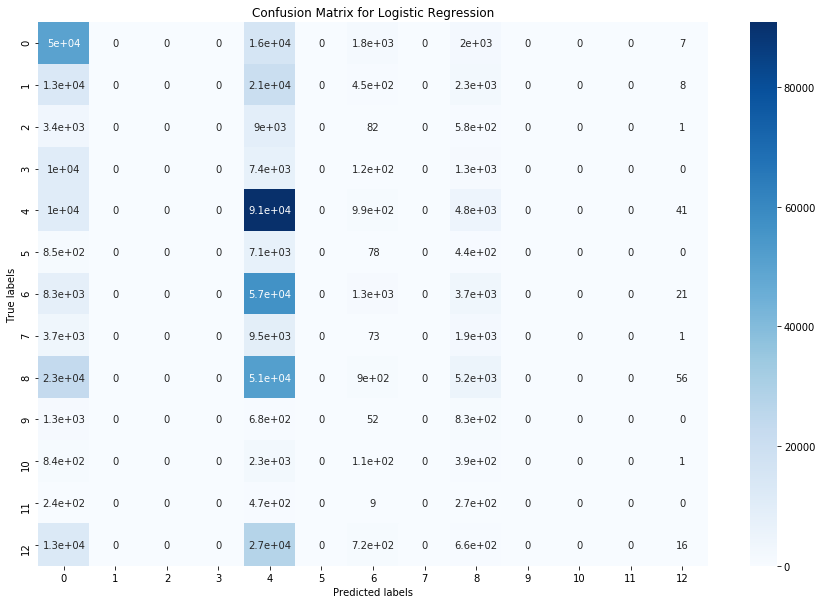

In [58]:
plt.rcParams['figure.figsize'] = [15, 10]
predLR = logRegr.predict(X_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predLR)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Logistic Regression'); 

plt.show()

In [59]:
print(metrics.classification_report(y_te, predLR))

             precision    recall  f1-score   support

        1.0       0.36      0.72      0.48     69992
        2.0       0.00      0.00      0.00     36910
        3.0       0.00      0.00      0.00     13081
        4.0       0.00      0.00      0.00     19130
        5.0       0.30      0.85      0.45    107147
        6.0       0.00      0.00      0.00      8479
        7.0       0.20      0.02      0.03     69991
        8.0       0.00      0.00      0.00     15251
        9.0       0.21      0.06      0.10     80898
       10.0       0.00      0.00      0.00      2877
       11.0       0.00      0.00      0.00      3645
       12.0       0.00      0.00      0.00       981
       13.0       0.11      0.00      0.00     41735

avg / total       0.20      0.31      0.20    470117



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Quadratic Discriminant Analysis (QDA)

In [60]:
QDAclf = QuadraticDiscriminantAnalysis()
QDAclf.fit(X_tr, y_tr.values.ravel()) 
QDAclf.score(X_te, y_te.values.ravel())

0.3667703997090086

In [61]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(QDAclf, X, y.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Quadratic Discriminant Analysis average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Quadratic Discriminant Analysis average accuracy: 0.248


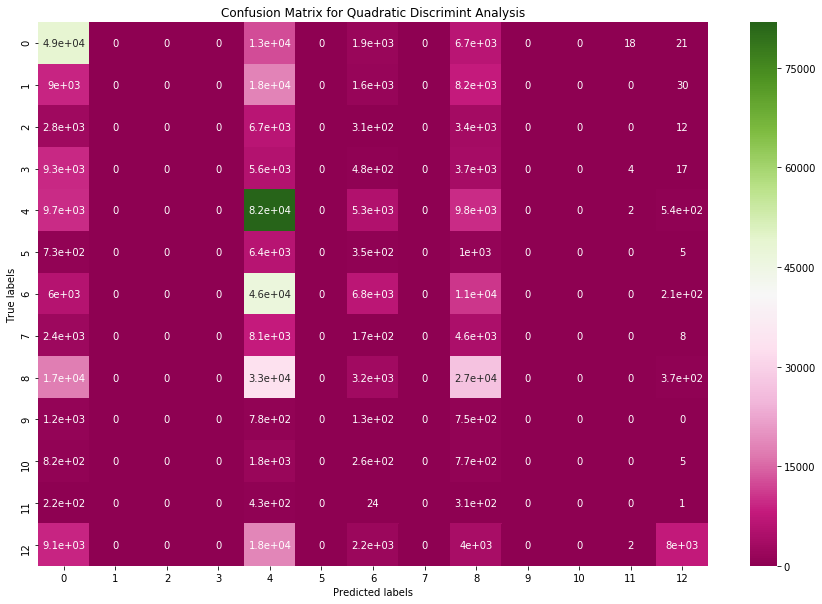

In [62]:
plt.rcParams['figure.figsize'] = [15, 10]
predQDA = QDAclf.predict(X_te)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predQDA)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="PiYG"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Quadratic Discrimint Analysis'); 
plt.show()

In [63]:
print(metrics.classification_report(y_te, predQDA))

             precision    recall  f1-score   support

        1.0       0.42      0.70      0.52     69992
        2.0       0.00      0.00      0.00     36910
        3.0       0.00      0.00      0.00     13081
        4.0       0.00      0.00      0.00     19130
        5.0       0.34      0.76      0.47    107147
        6.0       0.00      0.00      0.00      8479
        7.0       0.30      0.10      0.15     69991
        8.0       0.00      0.00      0.00     15251
        9.0       0.33      0.33      0.33     80898
       10.0       0.00      0.00      0.00      2877
       11.0       0.00      0.00      0.00      3645
       12.0       0.00      0.00      0.00       981
       13.0       0.87      0.19      0.31     41735

avg / total       0.32      0.37      0.29    470117



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Bayesian Classification

In [64]:
bclf = GaussianNB()
bclf.fit(X_tr, y_tr.values.ravel())
bclf.score(X_te, y_te.values.ravel())

0.33548669799220193

In [65]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(bclf, X, y.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Bayesian average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Bayesian average accuracy: 0.240


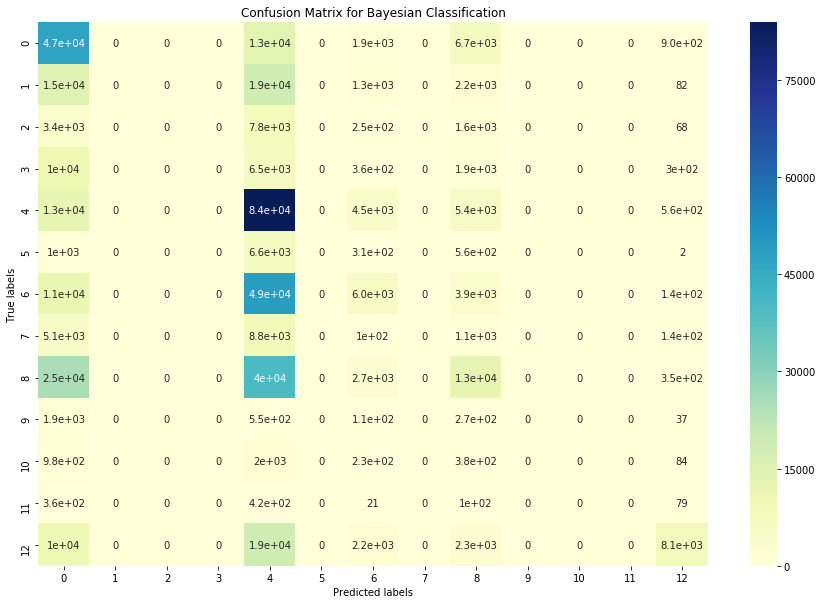

In [66]:
plt.rcParams['figure.figsize'] = [15, 10]
predB = bclf.predict(X_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predB)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Bayesian Classification'); 
plt.show()

In [67]:
print(metrics.classification_report(y_te, predB))

             precision    recall  f1-score   support

        1.0       0.33      0.67      0.44     69992
        2.0       0.00      0.00      0.00     36910
        3.0       0.00      0.00      0.00     13081
        4.0       0.00      0.00      0.00     19130
        5.0       0.33      0.78      0.46    107147
        6.0       0.00      0.00      0.00      8479
        7.0       0.30      0.09      0.13     69991
        8.0       0.00      0.00      0.00     15251
        9.0       0.32      0.16      0.21     80898
       10.0       0.00      0.00      0.00      2877
       11.0       0.00      0.00      0.00      3645
       12.0       0.00      0.00      0.00       981
       13.0       0.75      0.20      0.31     41735

avg / total       0.29      0.34      0.25    470117



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Notebook Run Time

In [68]:
print ( "Time %lf minutes.\n"%((int(time.time()-start_time_notebook))/60))

Time 42.616667 minutes.



## Conclusions

We ultimately decided that the ensemble extra trees classification algorithm was the best choice
for this particular dataset in predicting cause of fire. Throughout our various measures of
accuracy and validation this model continued to be the best choice. However, the highest level
of predictive capability we were able to attain was 45%, which leaves a lot of variation
unexplained. One potential cause behind this is the dataset uses two classes that are quite
ambiguous: miscellaneous and missing/undefined. These two classes alone account for
490,528 data points. We believe this omission in data points resulted in some decrease in
accuracy since they make up about 26% of the dataset. Since these algorithms’ performance
depend on well-defined classes, lacking the true fire causes of a large part of this dataset
greatly affects the accuracy of our model. However, we still feel that decision-tree based
algorithms are best suited to handle this dataset and that if we update the model with a new
dataset containing more well-defined classes and variables, the results would improve.

## Future Research

Although cause of fire is an interesting variable to predict as a measure of wildfire prevention, another interesting variable to predict is fire size. Should a fire still begin even with prevention policies in place, which is not an unusual case given that one of the main cause of fire in our analysis are debris burning, being able to estimate the fire size can serve as a second measure of prevention. If a fire is predicted to be significantly devastating once started, fire prevention authorities can make the appropriate preparations for a quick response to curb the fire from spreading. 

For cases where predicting fire size is the main focus, including a time variable (like day, month, and year) would likely result in higher precision than our model due to the presupposition that wildfires tend to have seasonalities. For instance, if California experienced dry seasons in 2012-2014 that led to more brush fires than previous years, the likelihood of a drought is high (as is the case for California from 2012-2017) and the model might suggest this pattern to carry on into 2015. This added information can increase risk prediction and further improve prevention measures. 

We understand that our model lacks this prediction ability and that a spatio-temporal regression model is often used in this type of fire prediction/analysis, (12).  However, we did not include this method in our project since such models were not covered over the course of our program, and we reserve this as a future research opportunity.


## Sources

1.    Géron, Aurélien. Hands-on Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. OReilly, 2018.

2. Holtz, Yan. “#92 Control Color in Seaborn Heatmaps.” The Python Graph Gallery, 13 Mar. 2018, python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/.

3. Li, Susan. “Building A Logistic Regression in Python, Step by Step.” Towards Data Science, Towards Data Science, 29 Sept. 2017, towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8.
4. .Press, Associated. “The Costs to Fight the Deadly Wildfires in the West Are Spiraling out of Control.” Business Insider, Business Insider, 15 Oct. 2017,
www.businessinsider.com/ap-us-states-struggle-to-pay-spiraling-cost-of-fighting-fires-2017-10.
5. "Precison Recall" http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
6.    “Sklearn.tree.DecisionTreeClassifier.” Scikit-Learn, scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html.
 
7.    Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
8.    “Sklearn.linear_model.LogisticRegression.” Http://Scikit-Learn.org/, scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.
9.    “Sklearn.linear_model.RidgeClassifier.” Scikit-Learn, scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html.
10. “Sklearn Plot Confusion Matrix with Labels.” Stack Overflow, stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels.
11.	Tatman, Rachael. “1.88 Million US Wildfires | Kaggle.” Countries of the World | Kaggle, 13 Sept. 2017, www.kaggle.com/rtatman/188-million-us-wildfires.
12. Taylor, S. W., et al. “Wildfire Prediction to Inform Fire Management: Statistical Science Challenges.” Statistical Science, vol. 28, no. 4, 2013, pp. 586–615., doi:10.1214/13-sts451.
13. 1404033991. “The Art of Effective Visualization of Multi-Dimensional Data.” Towards Data Science, Towards Data Science, 15 Jan. 2018, towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57.
14.    “1.2. Linear and Quadratic Discriminant Analysis.” Scikit-Learn , scikit-learn.org/stable/modules/lda_qda.html.
15.    “1.9. Naive Bayes.” Scikit-Learn, scikit-learn.org/stable/modules/naive_bayes.html.
16.    “3.2.4.3.1. Sklearn.ensemble.RandomForestClassifier.” Scikit-Learn, scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.
17.    “3.2.4.3.3. Sklearn.ensemble.ExtraTreesClassifier.” Scikit-Learn, scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html.

